# Severe Weather Capstone - EDA

Greg Welliver   

In [30]:
# Import relevant libraries and packages.
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import statsmodels.api as sm
from statsmodels.graphics.api import abline_plot
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn import linear_model, preprocessing 
import warnings
from scipy import stats
import re
from glob import glob, iglob
from datetime import datetime
from wordcloud import WordCloud, STOPWORDS
pd.options.display.float_format = '{:,}'.format
style_set = sns.set_style('whitegrid')
color_choice = 'plum'
#ax.yaxis.set_major_formatter('{x:,.0f}')
#sns.set_context('notebook', font_scale = 4)
sns.set_context('notebook')


%matplotlib inline
import pandas as pd
#from mpl_toolkits.basemap import Basemap


import geopandas as gpd
from shapely.geometry import Point, Polygon
import contextily as ctx



## abc



In [2]:
# load data
#df = pd.read_csv("../Data/StormEvents_details-ftp_v1.0_d2001_c20220425.csv")
df = pd.read_parquet("../Data/all_storm_data8.pqt")
#df = pd.read_csv("../Data/all_storm_data4.csv")

In [3]:
df.head(40).T

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
BEGIN_YEARMONTH,202202,202202,202202,202202,202202,202202,202202,202202,202202,202202,...,202201,202208,202208,202208,202208,202208,202208,202208,202208,202208
BEGIN_TIME,2118,800,200,1609,0,500,100,100,200,400,...,1200,1811,1839,1839,1225,1220,1218,1224,1224,1230
STATE,NEVADA,NEVADA,NEVADA,ATLANTIC SOUTH,AMERICAN SAMOA,AMERICAN SAMOA,KANSAS,KANSAS,MASSACHUSETTS,MASSACHUSETTS,...,OHIO,ILLINOIS,ILLINOIS,ILLINOIS,ILLINOIS,ILLINOIS,ILLINOIS,ILLINOIS,ILLINOIS,ILLINOIS
YEAR,2022,2022,2022,2022,2022,2022,2022,2022,2022,2022,...,2022,2022,2022,2022,2022,2022,2022,2022,2022,2022
MONTH_NAME,February,February,February,February,February,February,February,February,February,February,...,January,August,August,August,August,August,August,August,August,August
EVENT_TYPE,High Wind,Heavy Snow,Heavy Snow,Waterspout,Heavy Rain,Heavy Rain,Winter Storm,Winter Storm,Heavy Snow,Heavy Snow,...,Winter Weather,Hail,Thunderstorm Wind,Thunderstorm Wind,Thunderstorm Wind,Thunderstorm Wind,Thunderstorm Wind,Thunderstorm Wind,Thunderstorm Wind,Thunderstorm Wind
BEGIN_DATE_TIME,2022-02-20 21:18:00,2022-02-21 08:00:00,2022-02-22 02:00:00,2022-02-18 16:09:00,2022-02-02 00:00:00,2022-02-12 05:00:00,2022-02-01 01:00:00,2022-02-01 01:00:00,2022-02-13 02:00:00,2022-02-13 04:00:00,...,2022-01-16 12:00:00,2022-08-29 18:11:00,2022-08-29 18:39:00,2022-08-29 18:39:00,2022-08-29 12:25:00,2022-08-29 12:20:00,2022-08-29 12:18:00,2022-08-29 12:24:00,2022-08-29 12:24:00,2022-08-29 12:30:00
INJURIES_DIRECT,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
INJURIES_INDIRECT,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DEATHS_DIRECT,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


df['day_of_week'] = "NaN"

df['day_of_week']

In [4]:
#df['HPI'] = df['HPI'].astype(float)

In [5]:
#df['HPI'] = df['HPI'].str.replace(".", "")

### Ideas:
- count of event type - DONE
- trends in event type over time
- storms by state - DONE
- storms by county - would need to get county name back
- storm damage by county - would need to get county name back
- storm damage by state - DONE
- relationship between population density and damage
- relationship between home price index and damage
- relationship between population density and deaths
- relationship between storm area and damage
- correlation heatmap - DONE
- word cloud/word counts for event narratives
- start times - put in 2 hour bins

breakdown of most damaging storms - take something like the top 10
- most damaging storms - top 20
- breakdown by storm type, state


In [6]:
df['DAMAGE_PROPERTY'][:20]

0         0.0
1         0.0
2         0.0
3         0.0
4    50,000.0
5         0.0
6         0.0
7         0.0
8         0.0
9         0.0
10        0.0
11        0.0
12        0.0
13        0.0
14        0.0
15        0.0
16        0.0
17        0.0
18        0.0
19        0.0
Name: DAMAGE_PROPERTY, dtype: float64

df.style.format({"DAMAGE_PROPERTY": "{:,.0f}"})

df['DAMAGE_PROPERTY'] = df.apply(lambda x: "{:,}".format(x['DAMAGE_PROPERTY']), axis=1)

map code

import plotly.express as px

# fig = px.scatter_geo(df,lat='BEGIN_LAT',lon='BEGIN_LON', hover_name="id")
fig = px.scatter_geo(df,lat='BEGIN_LAT',lon='BEGIN_LON')
fig.update_layout(title = 'World map', title_x=0.5)
fig.show()

# setting the size of the map
fig = plt.figure(figsize=(12,9))

# creating the map - setting latitude and longitude
m = Basemap(projection = 'mill', llcrnrlat = -90, urcrnrlat = 90, llcrnrlon = -180, urcrnrlon = 180, resolution = 'c')

# drawing the coastline
m.drawcoastlines()
m.drawcountries(color='gray')
m.drawstates(color='gray')

# creating variable for latitude and longitude to list
lat = df['BEGIN_LAT'].tolist()
lon = df['BEGIN_LON'].tolist()

# plotting the map
m.scatter(lon, lat, latlon = True, s = 10, c = 'red', marker = 'o', alpha = 1)

plt.show()

In [7]:
#street_map = gpd.read_file('../Data/tl_2022_us_state.shp')

# designate coordinate system
crs = {'init':'espc:4326'}
# zip x and y coordinates into single feature
geometry = [Point(xy) for xy in zip(df['BEGIN_LON'], df['BEGIN_LAT'])]
# create GeoPandas dataframe
geo_df = gpd.GeoDataFrame(df,
 crs = crs,
 geometry = geometry)

gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.BEGIN_LON, df.BEGIN_LAT))

In [8]:
#print(gdf.head())

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# We restrict to South America.
ax = world[world.continent == 'North America'].plot(
    color='white', edgecolor='black')

# We can now plot our ``GeoDataFrame``.
gdf.plot(ax=ax, color='red')

plt.show()

df_map = df[df['BEGIN_LON'].notna()].reset_index(drop=True)

 
long = list(df_map.BEGIN_LON)
lat = list(df_map.BEGIN_LAT)
geometry = [Point(xy) for xy in zip(long,lat)]


wardlink = "../Data/tl_2022_us_state.shp"

ward = gpd.read_file(wardlink, bbox=None, mask=None, rows=None)
geo_df = gpd.GeoDataFrame(geometry = geometry)

ward.crs = {'init':"epsg:4326"}
geo_df.crs = {'init':"epsg:4326"}

# plot the polygon
ax = ward.plot(alpha=0.35, color='#d66058', zorder=1)
# plot the boundary only (without fill), just uncomment
#ax = gpd.GeoSeries(ward.to_crs(epsg=3857)['geometry'].unary_union).boundary.plot(ax=ax, alpha=0.5, color="#ed2518",zorder=2)
ax = gpd.GeoSeries(ward['geometry'].unary_union).boundary.plot(ax=ax, alpha=0.5, color="#ed2518",zorder=2)

# plot the marker
ax = geo_df.plot(ax = ax, markersize = 20, color = 'red',marker = '*',label = 'Delhi', zorder=3)

ctx.add_basemap(ax, crs=geo_df.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)
plt.show()

example capstones with maps: 
- https://github.com/connormca12/Springboard-Projects/blob/master/Capstone-1/data_storytelling.ipynb
- https://nbviewer.org/github/pratha19/NYC_taxi_trip_duration/blob/master/notebooks/NYC_EDA.ipynb

- https://github.com/LisaATaylor/Rideshare/blob/master/Chicago%20Rideshare%20-%20Wrangling+Visualization.ipynb

- https://stackoverflow.com/questions/63644131/how-to-use-geopandas-to-plot-latitude-and-longitude-on-a-more-detailed-map-with

- https://medium.com/@ianforrest11/graphing-latitudes-and-longitudes-on-a-map-bf64d5fca391

- shapefiles: https://www.census.gov/cgi-bin/geo/shapefiles/index.php?year=2022&layergroup=States+%28and+equivalent%29

df_map = df_map[df_map['BEGIN_LON'] > -125 ].reset_index(drop=True)
len(df_map)

df_map = df_map[df_map['BEGIN_LON'] < -50 ].reset_index(drop=True)
len(df_map)

df_map = df_map[df_map['BEGIN_LAT'] > 35 ].reset_index(drop=True)
len(df_map)

 
long = list(df_map.BEGIN_LON)
lat = list(df_map.BEGIN_LAT)
geometry = [Point(xy) for xy in zip(long,lat)]


wardlink = "../Data/tl_2022_us_state.shp"

ward = gpd.read_file(wardlink, bbox=None, mask=None, rows=None)
geo_df = gpd.GeoDataFrame(geometry = geometry)

ward.crs = {'init':"epsg:4326"}
geo_df.crs = {'init':"epsg:4326"}

# plot the polygon
ax = ward.plot(alpha=0.35, color='#d66058', zorder=1)
# plot the boundary only (without fill), just uncomment
#ax = gpd.GeoSeries(ward.to_crs(epsg=3857)['geometry'].unary_union).boundary.plot(ax=ax, alpha=0.5, color="#ed2518",zorder=2)
ax = gpd.GeoSeries(ward['geometry'].unary_union).boundary.plot(ax=ax, alpha=0.5, color="#ed2518",zorder=2)

# plot the marker
ax = geo_df.plot(ax = ax, markersize = 20, color = 'red',marker = '*',label = 'Delhi', zorder=3)

ctx.add_basemap(ax, crs=geo_df.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)
plt.show()

In [9]:
Years_Grouped = df['YEAR'].value_counts().reset_index()
Years_Grouped.index = Years_Grouped.index + 1
Years_Grouped.columns = ['YEAR', 'Count']
Years_Grouped.head(40)

,YEAR,Count
1,2022,137406
2,2021,122486
3,2000,104014
4,2011,79091
5,2008,71190
6,2019,67859
7,2012,64503
8,2010,62807
9,2018,62693
10,2020,61237


''

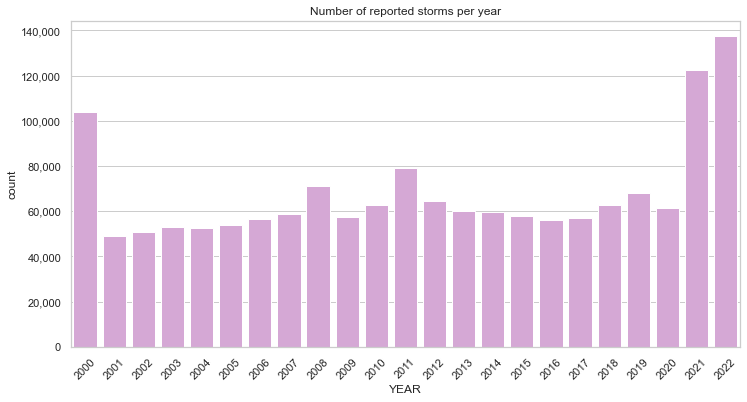

In [10]:
fig, ax = plt.subplots(figsize = (12 , 6))
plt.title("Number of reported storms per year")
sns.countplot(x='YEAR', data=df, color=color_choice)
plt.xticks(rotation=45)
ax.yaxis.set_major_formatter('{x:,.0f}')

;

''

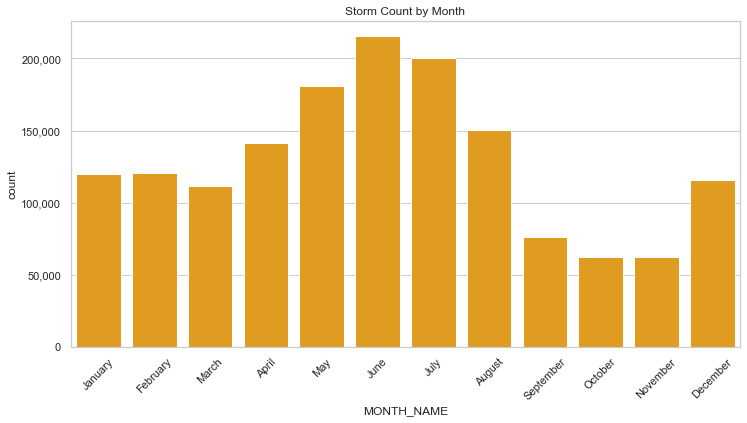

In [11]:
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
fig, ax = plt.subplots(figsize = (12 , 6))
plt.title("Storm Count by Month")
sns.countplot(x='MONTH_NAME', data=df, color='orange', order=month_order)
plt.xticks(rotation=45)
ax.yaxis.set_major_formatter('{x:,.0f}')
;

''

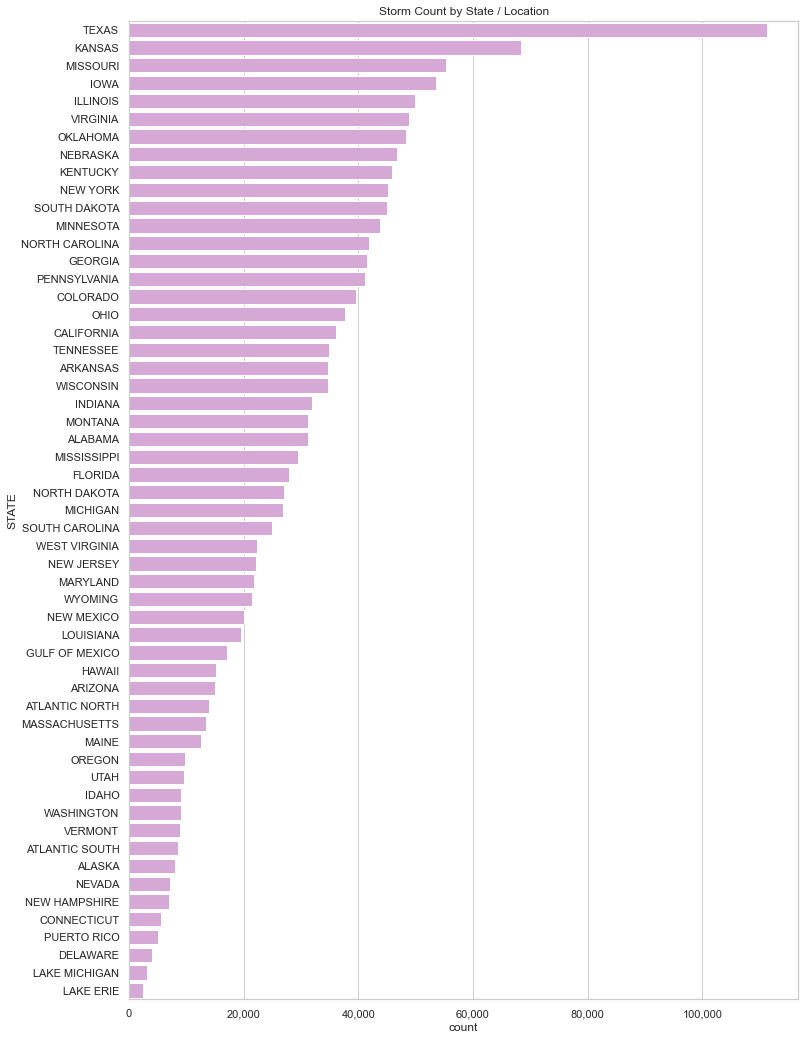

In [12]:
df_state = df[df.groupby('STATE')['STATE'].transform('size') > 2000].reset_index(drop=True)

#sns.set_palette("Bright")
fig, ax = plt.subplots(figsize = (12 , 18))
plt.title("Storm Count by State / Location")

sns.countplot(y='STATE', data=df_state, color='plum', order=df_state['STATE'].value_counts().index)
#sns.countplot(x='EVENT_TYPE', data=df_events, color='blue', order=df_events['EVENT_TYPE'].value_counts(ascending=True).index)
#plt.xticks(rotation=90)
ax.xaxis.set_major_formatter('{x:,.0f}')
;

In [13]:
df.EVENT_TYPE.value_counts()[:20]

Thunderstorm Wind           389050
Hail                        290487
Flash Flood                  94652
High Wind                    84971
Winter Storm                 82031
Winter Weather               77901
Drought                      76494
Heavy Snow                   65193
Flood                        59445
Marine Thunderstorm Wind     41302
Tornado                      36040
Heavy Rain                   29382
Heat                         25105
Strong Wind                  24516
Extreme Cold/Wind Chill      19669
Dense Fog                    15572
Lightning                    15307
Frost/Freeze                 14896
Blizzard                     14304
Excessive Heat               14131
Name: EVENT_TYPE, dtype: int64

''

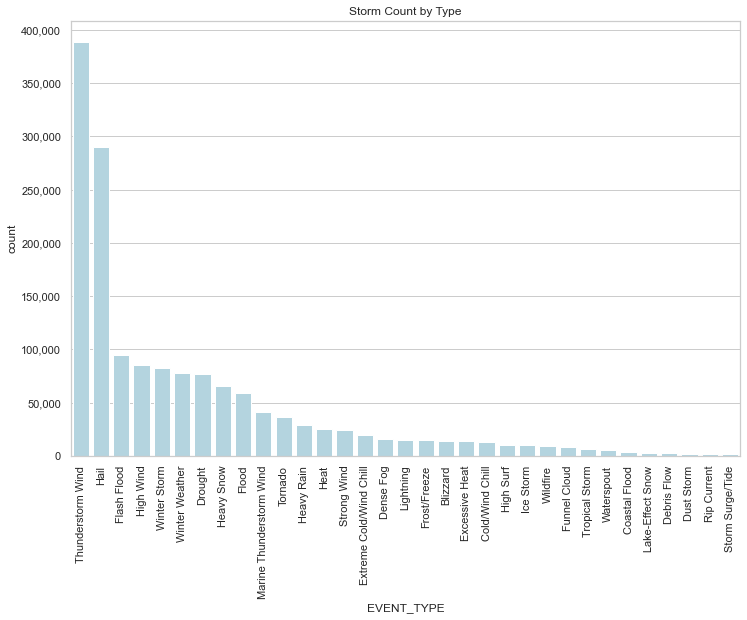

In [14]:
df_events = df[df.groupby('EVENT_TYPE')['EVENT_TYPE'].transform('size') > 1200].reset_index(drop=True)

#sns.set_palette("Bright")
#plt.figure(figsize=(12,6))
fig, ax = plt.subplots(figsize = (12 , 8))
plt.title("Storm Count by Type")

sns.countplot(x='EVENT_TYPE', data=df_events, color='lightblue', order=df_events['EVENT_TYPE'].value_counts().index)
#sns.countplot(x='EVENT_TYPE', data=df_events, color='blue', order=df_events['EVENT_TYPE'].value_counts(ascending=True).index)
plt.xticks(rotation=90)
ax.yaxis.set_major_formatter('{x:,.0f}')
;

In [15]:
df['DAMAGE_PROPERTY']

0               0.0
1               0.0
2               0.0
3               0.0
4          50,000.0
             ...   
1555642         0.0
1555643         0.0
1555644   300,000.0
1555645         0.0
1555646         0.0
Name: DAMAGE_PROPERTY, Length: 1555647, dtype: float64

In [16]:
df_damage = df.sort_values(by=['DAMAGE_PROPERTY'], ascending=False).T
df_damage

,1490928,1423421,1144380,1504196,1143765,1143599,916898,1143761,46711,702325,...,582068,582058,582067,582066,582065,582064,582063,582061,582060,1555646
BEGIN_YEARMONTH,200508,201811,201708,200510,201708,201708,201210,201708,202209,202209,...,201305,201304,201305,201305,201304,201304,201304,201304,201304,200112
BEGIN_TIME,200,633,2145,700,2200,1840,500,2000,1405,1405,...,2155,0,2155,2155,1609,1422,0,0,1418,700
STATE,LOUISIANA,CALIFORNIA,TEXAS,FLORIDA,TEXAS,TEXAS,NEW JERSEY,TEXAS,FLORIDA,FLORIDA,...,TEXAS,TEXAS,TEXAS,TEXAS,MISSISSIPPI,ILLINOIS,TEXAS,TEXAS,ILLINOIS,PUERTO RICO
YEAR,2005,2018,2017,2005,2017,2017,2012,2017,2022,2022,...,2013,2013,2013,2013,2013,2013,2013,2013,2013,2001
MONTH_NAME,August,November,August,October,August,August,October,August,September,September,...,May,April,May,May,April,April,April,April,April,December
EVENT_TYPE,Storm Surge/Tide,Wildfire,Flash Flood,Hurricane (Typhoon),Flash Flood,Flash Flood,Coastal Flood,Flash Flood,Hurricane,Hurricane,...,Cold/Wind Chill,Drought,Cold/Wind Chill,Cold/Wind Chill,Tornado,Hail,Drought,Drought,Hail,Flash Flood
BEGIN_DATE_TIME,2005-08-29 02:00:00,2018-11-08 06:33:00,2017-08-26 21:45:00,2005-10-24 07:00:00,2017-08-26 22:00:00,2017-08-26 18:40:00,2012-10-29 05:00:00,2017-08-27 20:00:00,2022-09-28 14:05:00,2022-09-28 14:05:00,...,2013-05-01 21:55:00,2013-04-01 00:00:00,2013-05-01 21:55:00,2013-05-01 21:55:00,2013-04-18 16:09:00,2013-04-10 14:22:00,2013-04-01 00:00:00,2013-04-01 00:00:00,2013-04-10 14:18:00,2001-12-22 07:00:00
INJURIES_DIRECT,0,12,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
INJURIES_INDIRECT,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DEATHS_DIRECT,0,86,36,1,3,3,0,3,60,60,...,0,0,0,0,0,0,0,0,0,0


In [17]:
df.sort_values('DAMAGE_PROPERTY').T

,0,965226,965225,965223,965222,965221,965220,965219,965227,965218,...,702325,1143761,46711,916898,1143599,1143765,1504196,1144380,1423421,1490928
BEGIN_YEARMONTH,202202,201601,201601,201602,201602,201602,201602,201603,201602,201603,...,202209,201708,202209,201210,201708,201708,200510,201708,201811,200508
BEGIN_TIME,2118,55,335,430,430,600,700,1930,1000,1830,...,1405,2000,1405,500,1840,2200,700,2145,633,200
STATE,NEVADA,VIRGINIA,VIRGINIA,SOUTH DAKOTA,SOUTH DAKOTA,SOUTH DAKOTA,SOUTH DAKOTA,IOWA,SOUTH DAKOTA,IOWA,...,FLORIDA,TEXAS,FLORIDA,NEW JERSEY,TEXAS,TEXAS,FLORIDA,TEXAS,CALIFORNIA,LOUISIANA
YEAR,2022,2016,2016,2016,2016,2016,2016,2016,2016,2016,...,2022,2017,2022,2012,2017,2017,2005,2017,2018,2005
MONTH_NAME,February,January,January,February,February,February,February,March,February,March,...,September,August,September,October,August,August,October,August,November,August
EVENT_TYPE,High Wind,Dense Fog,Dense Fog,High Wind,High Wind,Winter Weather,Blizzard,Winter Storm,Winter Weather,Winter Storm,...,Hurricane,Flash Flood,Hurricane,Coastal Flood,Flash Flood,Flash Flood,Hurricane (Typhoon),Flash Flood,Wildfire,Storm Surge/Tide
BEGIN_DATE_TIME,2022-02-20 21:18:00,2016-01-08 00:55:00,2016-01-08 03:35:00,2016-02-19 04:30:00,2016-02-19 04:30:00,2016-02-02 06:00:00,2016-02-02 07:00:00,2016-03-23 19:30:00,2016-02-29 10:00:00,2016-03-23 18:30:00,...,2022-09-28 14:05:00,2017-08-27 20:00:00,2022-09-28 14:05:00,2012-10-29 05:00:00,2017-08-26 18:40:00,2017-08-26 22:00:00,2005-10-24 07:00:00,2017-08-26 21:45:00,2018-11-08 06:33:00,2005-08-29 02:00:00
INJURIES_DIRECT,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,12,0
INJURIES_INDIRECT,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DEATHS_DIRECT,0,0,0,0,0,0,0,0,0,0,...,60,3,60,0,3,3,1,36,86,0


In [18]:
df_states = pd.DataFrame(df.groupby('STATE')['DAMAGE_PROPERTY'].sum().sort_values(ascending=False).reset_index()[:15])
df_states['DAMAGE_PROPERTY'] = df_states['DAMAGE_PROPERTY'] / 1000000000
df_states


,STATE,DAMAGE_PROPERTY
0,LOUISIANA,107.69998265
1,TEXAS,102.08505003
2,FLORIDA,79.58899878
3,MISSISSIPPI,29.55273556
4,CALIFORNIA,28.59933099
5,NEW JERSEY,27.60074823
6,PUERTO RICO,19.46622814
7,COLORADO,11.8027802
8,ALABAMA,10.30502141
9,MISSOURI,8.06758243


''

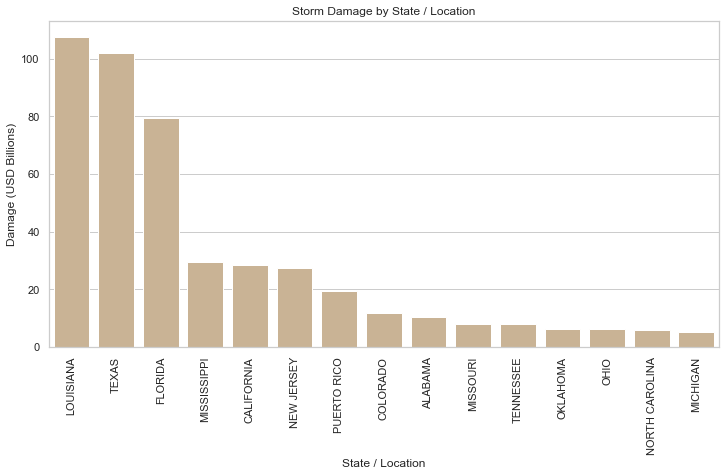

In [19]:
fig, ax = plt.subplots(figsize = (12 , 6))

#plt.figure(figsize=(12,6))
plt.title("Storm Damage by State / Location")
sns.barplot(x = 'STATE', y = 'DAMAGE_PROPERTY', data = df_states,
            color = 'tan'
            )

ax.set_ylabel("Damage (USD Billions)" , size = 12 )
ax.set_xlabel( "State / Location" , size = 12 )
plt.xticks(rotation=90)
;


''

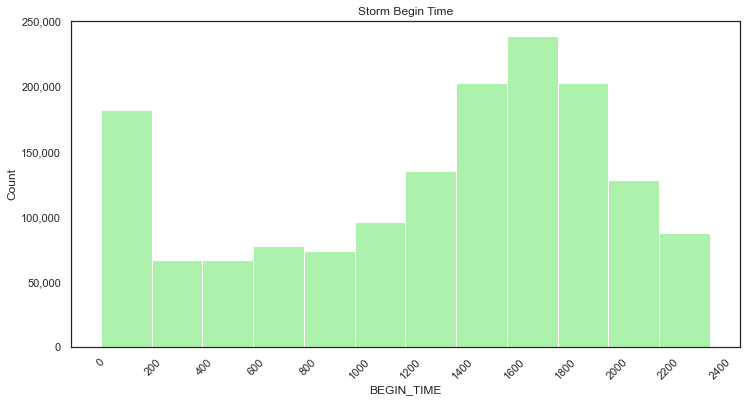

In [28]:
sns.set_style("white")
fig, ax = plt.subplots(figsize = (12 , 6))
plt.title("Storm Begin Time")
sns.histplot(x='BEGIN_TIME', data=df, color='lightgreen', bins=12)
plt.xticks(rotation=45)
ax.yaxis.set_major_formatter('{x:,.0f}')
plt.xticks(np.arange(0, 2400+100, 200))
;

In [21]:
Years_Grouped = df['STATE'].value_counts().reset_index()
Years_Grouped.index = Years_Grouped.index + 1
Years_Grouped.columns = ['STATE', 'Count']
Years_Grouped.head(40)

,STATE,Count
1,TEXAS,111174
2,KANSAS,68430
3,MISSOURI,55309
4,IOWA,53471
5,ILLINOIS,49823
6,VIRGINIA,48758
7,OKLAHOMA,48261
8,NEBRASKA,46783
9,KENTUCKY,45830
10,NEW YORK,45241


In [22]:
df.corr()

,BEGIN_YEARMONTH,BEGIN_TIME,YEAR,INJURIES_DIRECT,INJURIES_INDIRECT,DEATHS_DIRECT,DEATHS_INDIRECT,DAMAGE_PROPERTY,MAGNITUDE,TOR_LENGTH,TOR_WIDTH,BEGIN_LAT,BEGIN_LON,DURATION,STORM_AREA,PopDensity
BEGIN_YEARMONTH,1.0,-0.03919869980561563,0.9999904744095054,-0.00617271092384087,0.000253277086235931,0.00020800536807874482,0.014605457689619517,0.0007485229771306517,0.07923245782765753,0.0016456655712361347,0.013920528143037849,-0.026934813844558016,0.05449101600395935,0.0332511912554923,0.011643289596882827,0.01724681217376169
BEGIN_TIME,-0.03919869980561563,1.0,-0.03917502830685883,0.00028892109324939386,-0.0018794515310195672,-0.0022479771033221433,-0.009798339594095928,-0.001636156709438443,0.14996882184006385,0.026146300169729395,0.030889970943824476,0.04294250605868133,-0.00536192662555944,-0.4314204460825511,-0.07357030427380318,-0.0058100835076368715
YEAR,0.9999904744095054,-0.03917502830685883,1.0,-0.006181041181863849,0.00025287823996559004,0.00019571939893595368,0.014592367154060386,0.0007214805422359039,0.07901380903514775,0.0016632550906894082,0.013961983098446994,-0.027286073731696607,0.05442129735692803,0.03297235361138792,0.011642141631919338,0.01722358698485873
INJURIES_DIRECT,-0.00617271092384087,0.00028892109324939386,-0.006181041181863849,1.0,0.005075219075305023,0.1758708672789883,0.059966736691813474,0.08196163238269819,-0.006664676452376176,0.10305654884198076,0.1343185031055749,-0.006077092665655047,0.001566546358710834,0.001497008103788754,0.027003056153938942,0.000794310755867278
INJURIES_INDIRECT,0.000253277086235931,-0.0018794515310195672,0.00025287823996559004,0.005075219075305023,1.0,0.0006674088415945876,0.12319414221455606,0.04674927491467155,-0.002043516692873005,0.00036020882524502205,0.0006260059156300709,-0.002308052635502891,-0.002243616058827947,-0.0003182162697480724,0.004174651101233805,-0.00010983966801802125
DEATHS_DIRECT,0.00020800536807874482,-0.0022479771033221433,0.00019571939893595368,0.1758708672789883,0.0006674088415945876,1.0,0.05568920980392888,0.21663225004278044,-0.007144117238668074,0.029284712569275836,0.04320085651368691,-0.009649083766465541,0.00014580643259647547,-0.0005606072407168083,0.02881487064070151,0.0025815041998478424
DEATHS_INDIRECT,0.014605457689619517,-0.009798339594095928,0.014592367154060386,0.059966736691813474,0.12319414221455606,0.05568920980392888,1.0,0.06304871954325235,-0.013641865871431598,0.004563293398818144,0.006420763679547456,-0.003431866728437854,-0.0037480529844389557,-0.00335453030481138,0.01860617542189843,0.0028600320522594487
DAMAGE_PROPERTY,0.0007485229771306517,-0.001636156709438443,0.0007214805422359039,0.08196163238269819,0.04674927491467155,0.21663225004278044,0.06304871954325235,1.0,-0.004670442229409922,0.009342790992440085,0.014040001633286853,-0.009826840945699999,-0.0002394579521008737,0.0010100041924322508,0.02259456686132373,0.002483530457335198
MAGNITUDE,0.07923245782765753,0.14996882184006385,0.07901380903514775,-0.006664676452376176,-0.002043516692873005,-0.007144117238668074,-0.013641865871431598,-0.004670442229409922,1.0,-0.03976580126778751,-0.04408207953920891,0.01843746008421094,0.18321542761169723,-0.15000378957208402,-0.09283522504553512,-0.005813586185724675
TOR_LENGTH,0.0016456655712361347,0.026146300169729395,0.0016632550906894082,0.10305654884198076,0.00036020882524502205,0.029284712569275836,0.004563293398818144,0.009342790992440085,-0.03976580126778751,1.0,0.5238966821520907,-0.020744360771925145,-0.006176838401550505,-0.019902398692552243,0.12465234258124264,-0.007900664324403553


In [23]:
#let's select only the audio features:
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1555647 entries, 0 to 1555646
Data columns (total 27 columns):
 #   Column             Non-Null Count    Dtype         
---  ------             --------------    -----         
 0   BEGIN_YEARMONTH    1555647 non-null  int64         
 1   BEGIN_TIME         1555647 non-null  int64         
 2   STATE              1555647 non-null  object        
 3   YEAR               1555647 non-null  int64         
 4   MONTH_NAME         1555647 non-null  object        
 5   EVENT_TYPE         1555647 non-null  object        
 6   BEGIN_DATE_TIME    1555647 non-null  datetime64[ns]
 7   INJURIES_DIRECT    1555647 non-null  int64         
 8   INJURIES_INDIRECT  1555647 non-null  int64         
 9   DEATHS_DIRECT      1555647 non-null  int64         
 10  DEATHS_INDIRECT    1555647 non-null  int64         
 11  DAMAGE_PROPERTY    1555647 non-null  float64       
 12  MAGNITUDE          1555647 non-null  float64       
 13  MAGNITUDE_TYPE     517597 n

In [24]:
# set up dataframe for correlation matrix
df_corr = df[['INJURIES_DIRECT', 'INJURIES_INDIRECT','DEATHS_DIRECT', 'DEATHS_INDIRECT', 'DAMAGE_PROPERTY', 'MAGNITUDE', 'TOR_LENGTH', 'TOR_WIDTH', 'BEGIN_LAT','BEGIN_LON', 'DURATION', 'STORM_AREA', 'PopDensity']]

''

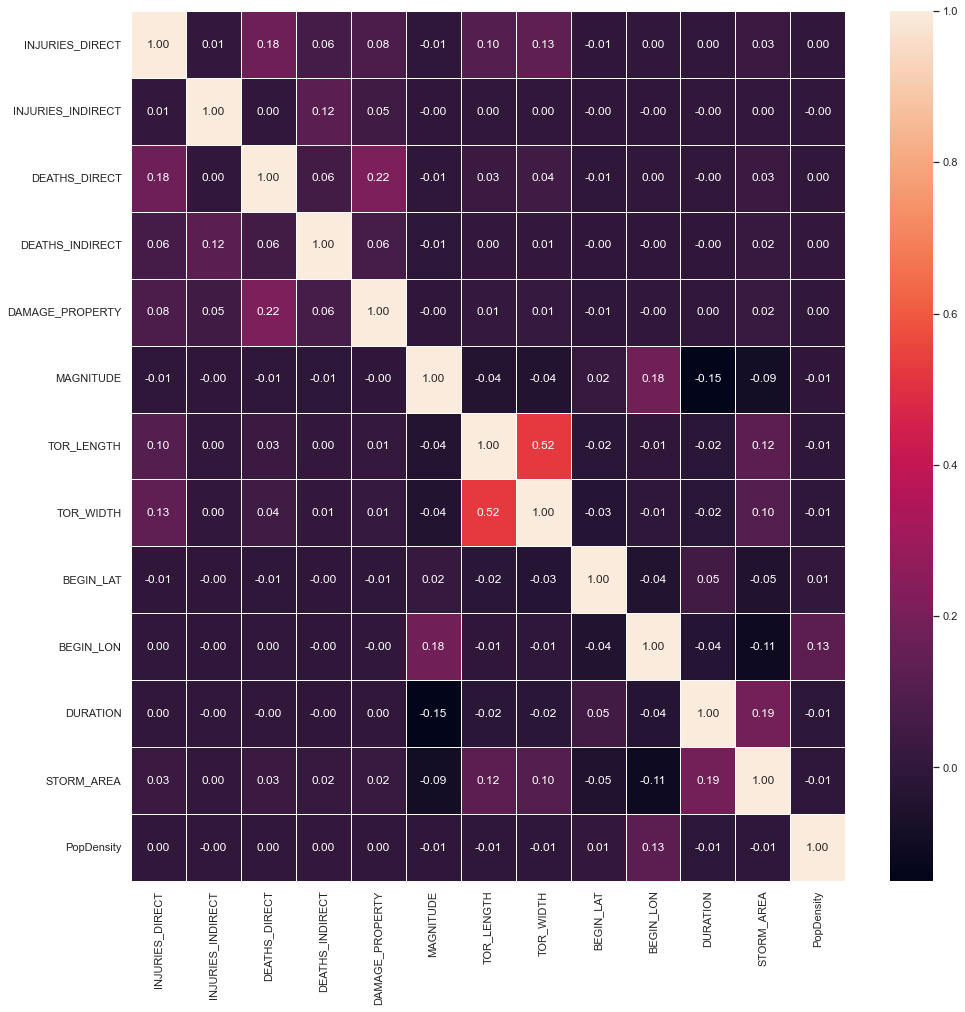

In [25]:
sns.set(font_scale=1)
f, ax = plt.subplots(figsize=(16, 16))
sns.heatmap(df_corr.corr(), annot=True, linewidths=.5, ax=ax, fmt='.2f')
#sns.heatmap(df_af.corr(), annot=True, linewidths=.5, ax=ax, fmt='n')
;

In [26]:
#df['YEAR'].unique().sort_values()

In [27]:
df.groupby([df['YEAR']]).count()

,BEGIN_YEARMONTH,BEGIN_TIME,STATE,MONTH_NAME,EVENT_TYPE,BEGIN_DATE_TIME,INJURIES_DIRECT,INJURIES_INDIRECT,DEATHS_DIRECT,DEATHS_INDIRECT,...,TOR_WIDTH,BEGIN_LAT,BEGIN_LON,EPISODE_NARRATIVE,EVENT_NARRATIVE,ST_CT_FIPS,DURATION,STORM_AREA,PopDensity,HPI
YEAR,,,,,,,,,,,,,,,,,,,,,
2000,104014,104014,104014,104014,104014,104014,104014,104014,104014,104014,...,104014,48640,48636,61666,30908,104014,104014,48636,70762,104014
2001,48875,48875,48875,48875,48875,48875,48875,48875,48875,48875,...,48875,25300,25297,25633,15754,48875,48875,25297,34245,48875
2002,50936,50936,50936,50936,50936,50936,50936,50936,50936,50936,...,50936,26522,26522,26680,17027,50936,50936,26522,35068,50936
2003,52955,52955,52955,52955,52955,52955,52955,52955,52955,52955,...,52955,27397,27397,26746,18969,52955,52955,27397,37192,52955
2004,52409,52409,52409,52409,52409,52409,52409,52409,52409,52409,...,52409,26988,26986,25777,19520,52409,52409,26986,35961,52409
2005,53976,53976,53976,53976,53976,53976,53976,53976,53976,53976,...,53976,33013,33013,26519,20114,53976,53976,33013,36344,53976
2006,56400,56400,56400,56400,56400,56400,56400,56400,56400,56400,...,56400,33825,33825,28300,23973,56400,56400,33825,40418,56400
2007,59010,59010,59010,59010,59010,59010,59010,59010,59010,59010,...,59010,35722,35722,59010,33904,59010,59010,35722,39597,59010
2008,71190,71190,71190,71190,71190,71190,71190,71190,71190,71190,...,71190,46824,46824,71190,44586,71190,71190,46824,50219,71190


### word cloud
df['EPISODE_NARRATIVE'] = df['EPISODE_NARRATIVE'].astype('str')
title_corpus = ' '.join(df['EPISODE_NARRATIVE'])
title_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white', height=2000, width=4000).generate(title_corpus)
plt.figure(figsize=(16,8))
plt.imshow(title_wordcloud)
plt.axis('off')
plt.show()


#### write to CSV
from pathlib import Path  
filepath = Path('/Users/gregwelliver/Desktop/springboard_files/Severe-Weather-Repo/Data/all_storm_data5.csv')  
filepath.parent.mkdir(parents=True, exist_ok=True)  
df.to_csv(filepath)

#### write to parquet
parquet_file = 'example_pd.parquet'

df.to_parquet(parquet_file, engine = 'pyarrow', compression = 'gzip')

logging.info('Parquet file named "%s" has been written to disk', parquet_file)

#### write to parquet
from pathlib import Path  
filepath = Path('/Users/gregwelliver/Desktop/springboard_files/Severe-Weather-Repo/Data/all_storm_data8.pqt')  
filepath.parent.mkdir(parents=True, exist_ok=True)  
df.to_parquet(filepath)

resources

CZ FIPS documentation: https://www.irsa.miami.edu/_assets/pdf/Documents/fips_statecounty_code.pdf

Population density: https://covid19.census.gov/datasets/21843f238cbb46b08615fc53e19e0daf_1/explore?location=2.632620%2C0.315550%2C1.00

Home price index: https://www.fhfa.gov/DataTools/Downloads/Pages/House-Price-Index-Datasets.aspx

maybe useful: https://www.nar.realtor/research-and-statistics/housing-statistics/county-median-home-prices-and-monthly-mortgage-payment
        
land values: https://www.nass.usda.gov/Publications/Todays_Reports/reports/land0822.pdf

drop columns
# WORKING, MARKDOWN UNTIL FINAL
# drop unnecessary columns
df.drop(['', '', '', '',], axis=1, inplace=True)